In [2]:
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, eye, lil_matrix
from scipy.sparse.linalg import spsolve
import sympy as sp
import numpy as np

In [3]:
def fd_weights ( offsets , order , show_system = False ) :

    """
    Name          : fd_weights -> finite difference weights
    Purpose       : calculate the set of coefficients for a finite difference
                    approximation of the order-th derivative using the given
                    offsets. We are essentually solving the linear system
                    A c = b, where A is the Vandermonde matrix of the offsets,
                    c is the vector of coefficients we want to find, and b is
                    a vector of zeros with a factorial(order) in the order-th
                    position.
    Author          : christlieb, augmented by Joshua Belieu.
    Date augmented  : 2025-08-26
    Last modified   : 2025-08-26
    Inputs :
        - offsets     : list. list of offsets (in units of grid stride h)
        - order       : int. order of derivative to approximate
        - show_system : bool. if True, print the system of equations being
                        solved. default is False.
    Outputs:
        - <ret>: <type> ... <meaning/units/shape>
    Dependencies:
        - None.
    """

    '''
    list of offsets (in units of grid stride h), nsimplify allows floats.
    '''

    s = [ sp.nsimplify ( offset ) for offset in offsets ]
    m = len ( s )

    '''
    the Vandermonde matrix of the offsets. the "A" in our system Ac = b
    '''

    A = sp.Matrix ([[ s[j] ** k for j in range ( m ) ] for k in range ( m )])

    '''
    a vector of zeros with a factorial(order) in the order-th position. the 
    "b" in our system Ac = b.
    '''

    b = sp.Matrix ( [ 0 ] * m )
    b [ order ] = sp.factorial ( order )

    '''
    the coefficients we want to find. the "c" in our system Ac = b. LUsolve is 
    a decomposition method that splits A into a lower and upper triangular matrix
    and solves the system (Ux=y and Ly=c) in two steps.
    '''

    c = A.LUsolve ( b )

    if show_system :

        system = sp.Eq( sp.MatMul ( A , c , evaluate = False ) , b )
        sp.pprint(system)

    return sp.simplify ( c )

'''
unit test :    
'''

fd_weights ( [ -1 , 0 , 1 ] , 2 )


Matrix([
[ 1],
[-2],
[ 1]])

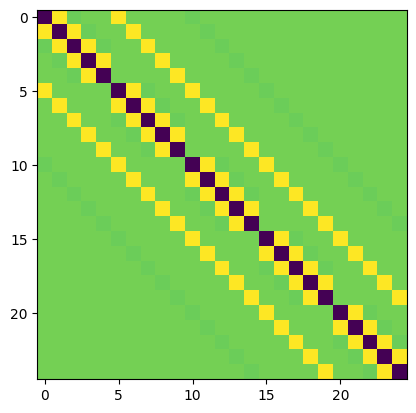

In [4]:
def build_2d_laplacian ( nx = 5 , ny = 5 , offsets = [ -1 , 0 , 1 ] ) :

    n = nx * ny

    hx = 1/(nx-1)
    hy = 1/(ny-1)

    a = lil_matrix ( ( n , n ) )

    x_weights = fd_weights ( offsets , 2 )
    y_weights = fd_weights ( offsets , 2 )

    for j in range ( ny ) :
        for i in range ( nx ) :

            idx = j * nx + i

            for iter_x , x_offset in enumerate ( offsets ) :

                i_offset = i + x_offset

                if i_offset >= 0 and i_offset < nx :

                    column = j * nx + i_offset

                    a [ idx , column ] += x_weights [ iter_x ] / hx ** 2

            for iter_y , offset in enumerate ( offsets ) :

                j_offset = j + offset

                if j_offset >= 0 and j_offset < ny :

                    column = j_offset * ny + i

                    a [ idx , column ] += y_weights [ iter_y ] / hy ** 2

    return a.tocsr()

'''
unit test
'''
  
test_derivative_matrix = build_2d_laplacian(offsets=[-2,-1,0,1,2])
plt.imshow(test_derivative_matrix.toarray(), cmap='viridis', interpolation='none');

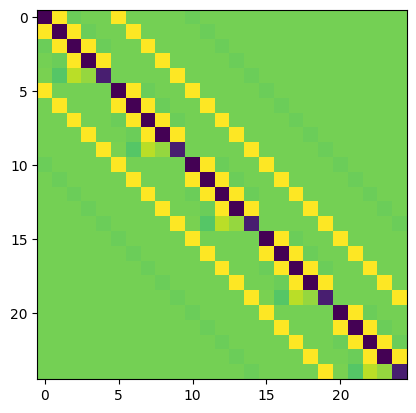

In [5]:
def neumann_boundary_condition(derivative_matrix, boundary_site='right',
                               boundary_offsets=[0, -1, -2], xb=1, yb=1):

    a = derivative_matrix.tolil()
    nx = int(np.sqrt(derivative_matrix.shape[0]))
    ny = int(np.sqrt(derivative_matrix.shape[1]))
    hx = xb / (nx - 1)
    hy = yb / (ny - 1)

    weights = fd_weights(boundary_offsets, 1)

    for j in range ( ny ) :
        for i in range ( nx ) :
            idx = j * nx + i

            if boundary_site == 'right' and i == nx - 1 :
                for offset , weight in zip ( boundary_offsets , weights ) :

                    col = j * nx + ( i + offset )

                    if 0 <= i + offset < nx :

                        a [ idx , col ] += weight / hx

            if boundary_site == 'left' and i == 0 :

                for offset , weight in zip ( boundary_offsets , weights ) :

                    col = j * nx + ( i + offset )

                    if 0 <= i + offset < nx :

                        a [ idx , col ] += weight / hx

            if boundary_site == 'upper' and j == ny - 1 :

                for offset , weight in zip ( boundary_offsets , weights ) :

                    row = j + offset

                    if 0 <= row < ny :

                        col = row * nx + i

                        a [ idx , col ] += weight / hy

            if boundary_site == 'bottom' and j == 0 :

                for offset , weight in zip ( boundary_offsets , weights ) :

                    row = j + offset

                    if 0 <= row < ny :

                        col = row * nx + i
                        
                        a [ idx , col ] += weight / hy

    return a.tocsr()

test = neumann_boundary_condition(test_derivative_matrix,boundary_offsets = [ 0,-1,-2,-3,-4 ])
plt.imshow(test.toarray(), cmap='viridis', interpolation='none');

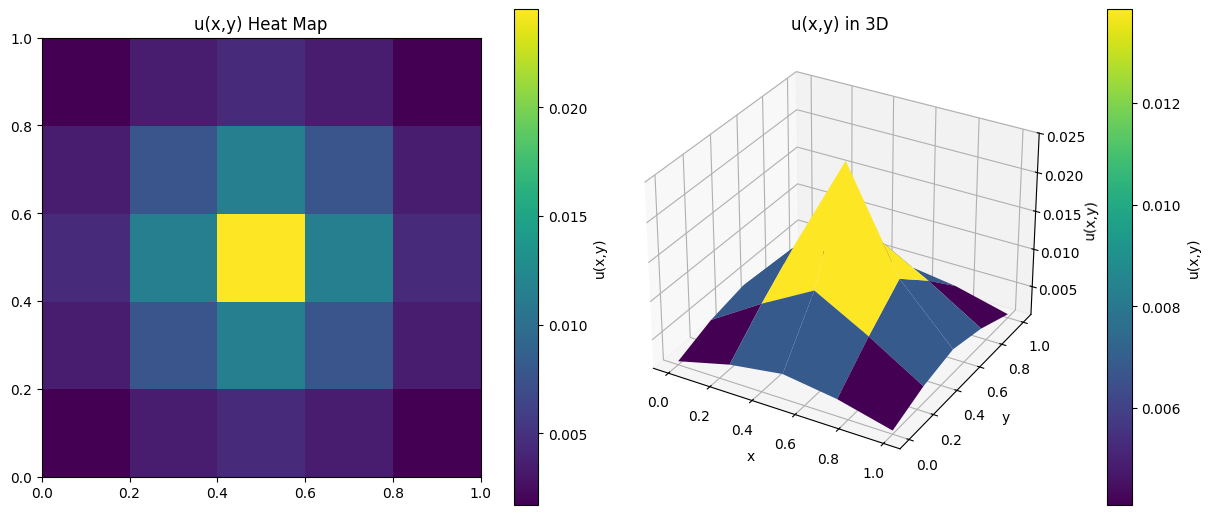

In [6]:
n=5
L = 1 ; H = 1
x = np.linspace ( 0 , L , n ); y = np.linspace ( 0 , H , n )

f = np.zeros((n,n))

for i in range ( n ) :
    for j in range ( n ) :
        if 1/3 <= x[i] <= 1/2 and 1/2 <= y[j] <= 2/3 :
            f[i,j] = -1

f = f.flatten()

u = spsolve(test_derivative_matrix.tocsr(), f) # cheese
U = u.reshape((n, n))

X, Y = np.meshgrid(x, y)

fig = plt.figure ( figsize = ( 12 , 10 ) , constrained_layout=True )
ax1 = fig.add_subplot ( 121 )
ax2 = fig.add_subplot ( 122 , projection = '3d' )

im1 = ax1.imshow(u.reshape((n,n)), origin="lower", extent=[0,1,0,1])
fig.colorbar(im1 , label="u(x,y)",ax=ax1 , shrink = 0.5 )
ax1.set_title("u(x,y) Heat Map")

im2 = ax2.plot_surface(X, Y, U, cmap='viridis', edgecolor="none")
fig.colorbar(im2 , shrink = 0.5 , aspect=20, label="u(x,y)")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("u(x,y)")
ax2.set_title("u(x,y) in 3D");

In [7]:
n = 5
laplacian_offsets = [ -2 , -1 , 0 , 1 , 2 ]
neumann_offsets = [ 0,-1,-2,-3,-4 ]
neumann_boundary = 'right'
L = 1 ; H = 1
x = np.linspace ( 0 , L , n ); y = np.linspace ( 0 , H , n )

f = np.zeros((n,n))
for i in range ( n ) :
    for j in range ( n ) :
        if 1/3 <= x[i] <= 1/2 and 1/2 <= y[j] <= 2/3 :
            f[i,j] = -1
f = f.flatten()

a = build_2d_laplacian( nx = n , ny = n , offsets = laplacian_offsets )
a_neumann = neumann_boundary_condition( a , boundary_site = neumann_boundary ,
                                       boundary_offsets = neumann_offsets ,
                                        xb = L , yb = H )